## Spotify Dataset Exploratory Data Analysis
Aaron Bishop (github@foozbat.net)

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Import Spotify dataset and do some initial exploration

In [84]:
df = pd.read_csv("dataset.csv")
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [94]:
print("Dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Number of duplicate rows:", df.duplicated().sum())
print("Number of duplicate tracks:", df['track_id'].duplicated().sum())
print("Columns with non-numeric values:", df.select_dtypes(exclude=['number']).columns.tolist())

Dataset shape: (113999, 21)
Missing values:
 Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Number of duplicate rows: 0
Number of duplicate tracks: 24259
Columns with non-numeric values: ['track_id', 'artists', 'album_name', 'track_name', 'explicit', 'track_genre']


In [86]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


It looks like there is only one row in the dataset without artist name, album name, and track name.  The rest of the row still contains useful data, so we'll keep it.

#### Initial data pre-processing

In [89]:
# drop null values
df.dropna(inplace=True)

# drop columns with unique identifiers or non-categorical text values
df2 = df.drop(columns=['track_id', 'track_name', 'album_name','artists'])

# convert non-numeric values to numeric
df2['explicit'] = df2['explicit'].astype(int)

df2['track_genre'] = pd.Categorical(df2['track_genre'])
genre_codes = dict(enumerate(df2['track_genre'].cat.categories)) # store these for later in case we need them
df2['track_genre'] = df2['track_genre'].cat.codes

df2.head()

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


#### Check for outliers

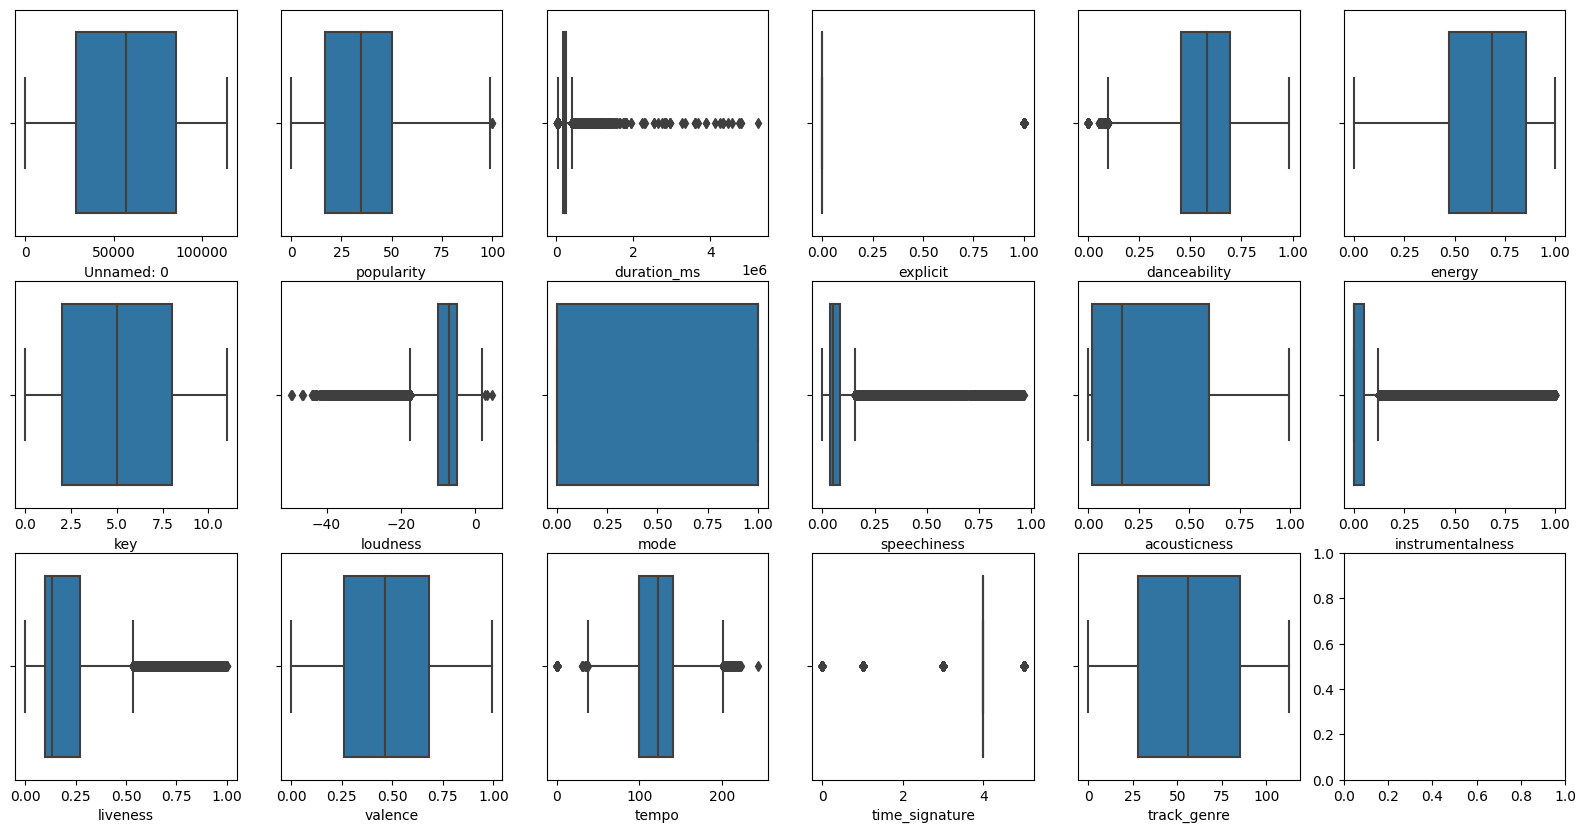

In [91]:
features = df2.columns.tolist()
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
for i, feature in enumerate(features):
    sns.boxplot(x=df2[feature], ax=axs[i//6, i%6])
plt.show()

It looks like time_signature, tempo, danceability, and popularity have some outliers.  Let's investigate.

In [92]:
print("Non-typical time signatures:")
print("0/4 Time: ", len(df[df['time_signature'] == 0]))
print("1/4 Time: ", len(df[df['time_signature'] == 1]))
print()

df[df['popularity'] == 100]


Non-typical time signatures:
0/4 Time:  163
1/4 Time:  973



,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20001,20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,dance
81051,81051,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,pop
